##Import various python functions and modules that we need.

In [1]:
from pandas import DataFrame
from IPython.display import FileLink

##Pylab namespace and inline plots. Import Rmagic.

In [2]:
%matplotlib inline
%load_ext rpy2.ipython

##Import R libraries we'll use.

In [3]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)

Use suppressPackageStartupMessages to eliminate package startup messages.
foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com
Loading required package: iterators
Loading required package: parallel
Loading required package: grid


##Import data into R. Prune to relevant samples (PS, non-bulk). Get rid of OTUs not observed in at least 25% of samples)

###These files are from the [binning notebook](./OTU_binning.ipynb), [tree notebook](./Tree.ipynb), [merge mappers notebook](./Merge_mappers.ipynb) 

In [4]:
%%R
physeq = import_biom("/var/seq_data/priming_exp/data/otu_table.biom", "/var/seq_data/priming_exp/data/otusn.tree")
sample.data = import_qiime_sample_data("/var/seq_data/priming_exp/data/allsample_metadata_nomock.txt")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)
physeq.PE = prune_samples((physeq.md$Bulk == 0), physeq)
physeq.PE.snorm = transform_sample_counts(physeq.PE, function(x) x/sum(x))
physeq.PE.thresh = filter_taxa(physeq.PE.snorm, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)
print(physeq.PE.thresh)


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3203 taxa and 395 samples ]
sample_data() Sample Data:       [ 395 samples by 11 sample variables ]
phy_tree()    Phylogenetic Tree: [ 3203 tips and 3202 internal nodes ]


In [5]:
%%R
print(colnames(physeq.md))

 [1] "Sample"      "FractionNum" "Treatment"   "Day"         "Density"    
 [6] "Bulk"        "Control"     "CC"          "X100"        "X700"       
[11] "H2O"        


###Calculate pairwise weighted unifrac distances between samples.

In [6]:
%%R
registerDoParallel(cores=20)
wunif.dist = distance(physeq.PE.thresh, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

###Ordinate using weighted unifrac distnaces with NMDS.

In [7]:
%%R
nmds = ordinate(physeq.PE.thresh, 
                method = "NMDS", 
                distance = wunif.dist)

Run 0 stress 0.08445914 
Run 1 stress 0.08484885 
... procrustes: rmse 0.003212934  max resid 0.04774741 
Run 2 stress 0.09445683 
Run 3 stress 0.09182875 
Run 4 stress 0.08617995 
Run 5 stress 0.0852092 
Run 6 stress 0.08769381 
Run 7 stress 0.09976203 
Run 8 stress 0.09698846 
Run 9 stress 0.09812441 
Run 10 stress 0.08462307 
... procrustes: rmse 0.001594281  max resid 0.02277569 
Run 11 stress 0.08695703 
Run 12 stress 0.09443187 
Run 13 stress 0.08497143 
Run 14 stress 0.09410241 
Run 15 stress 0.09157183 
Run 16 stress 0.1047505 
Run 17 stress 0.1105467 
Run 18 stress 0.1053715 
Run 19 stress 0.09401967 
Run 20 stress 0.09352584 


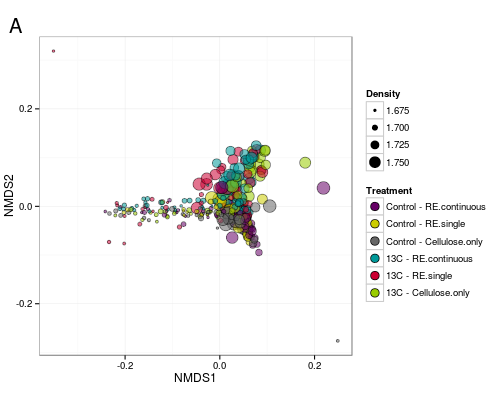

In [8]:
%%R -w 500 -h 400 

#colours = c("#ff7f00", "#377eb8", "#4daf4a", "#00f5ff", "#ff4040", "#68228b")
colours = c("#660066", "#CCCC00", "#666666", "#009999", "#CC0033", "#99CC00")

df = plot_ordination(physeq.PE.thresh, nmds, justDF = TRUE)
df$Density = as.numeric(as.character(df$Density))

p1 = ggplot(df, aes(x = NMDS1, y = NMDS2)) 
p1 = p1 + geom_point(aes(fill = Treatment, size = Density, alpha = 0.85), shape=21) 
p1 = p1 + scale_fill_manual(values = colours,
                            breaks=c("12C100", "12C700", "12CC", "13C100", "13C700", "13CC"),
                            labels=c("Control - RE.continuous", "Control - RE.single", "Control - Cellulose.only",
                                     "13C - RE.continuous", "13C - RE.single", "13C - Cellulose.only"))
p1 = p1 + guides(alpha = FALSE)
p1 = p1 + scale_size_area(aesthetics = "Density")
p1 = p1 + ggtitle("A")
p1 = p1 + guides(fill = guide_legend(override.aes = list(size = 4)))
p1 = p1 + guides(size = guide_legend(override.aes = list(fill = "black")))
p1 = p1 + theme_bw()
p1 = p1 + theme(plot.margin = unit(c(1,0,1,0), "lines"))
p1 = p1 + theme(plot.title = element_text(hjust = -0.1, size = 20))

p1

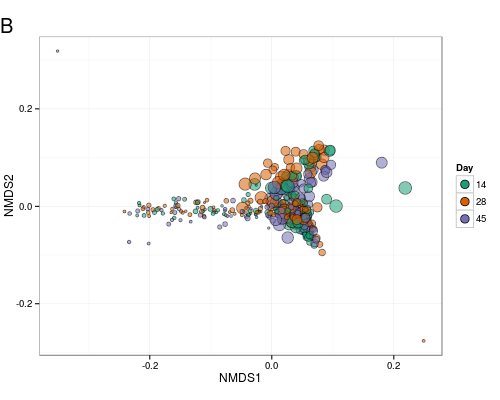

In [9]:
%%R -w 500 -h 400

p2 = ggplot(df, aes(x = NMDS1, y = NMDS2))
p2 = p2 + geom_point(aes(fill = factor(Day), size = Density, alpha = 0.85), shape=21)
p2 = p2 + scale_fill_brewer(palette="Dark2")
p2 = p2 + guides(alpha = FALSE, size = FALSE)
p2 = p2 + scale_size_area(aesthetics = "Density")
p2 = p2 + ggtitle("B")
p2 = p2 + guides(fill = guide_legend(title = "Day", override.aes = list(size = 4)))
p2 = p2 + theme_bw()
p2 = p2 + theme(plot.margin = unit(c(1,0,1,0), "lines"))
p2 = p2 + theme(plot.title = element_text(hjust = -0.1, size = 20))

p2

NULL


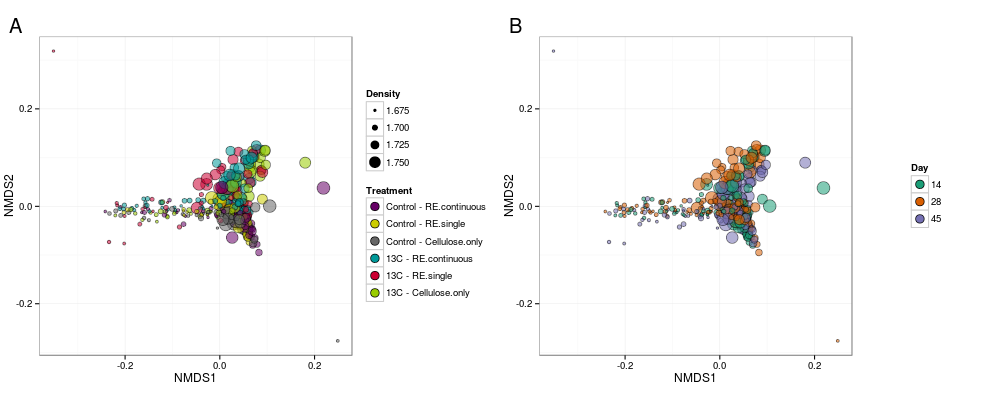

In [10]:
%%R -w 1000 -h 400

gp1 = ggplot_gtable(ggplot_build(p1))
gp2 = ggplot_gtable(ggplot_build(p2))
maxWidth = unit.pmax(gp1$widths[2:5], gp2$widths[2:5])

gp1$widths[2:5] <- maxWidth
gp2$widths[2:5] <- maxWidth

p.combined = grid.arrange(gp1, gp2, ncol = 2)
p.combined

In [11]:
%%R 
pdf("figs/full_ordination.pdf", width = 12, height = 5)
grid.arrange(p1, p2, widths = c(1.3, 1), ncol=2)
dev.off()

png 
  2 


In [12]:
FileLink("figs/full_ordination.pdf")

/home/ashley/priming_exp/figs/full_ordination.pdf

In [17]:
%%R 
png("figs/full_ordination.png", width = 1000, height = 500)
grid.arrange(p1, p2, widths = c(1.3, 1), ncol=2)
dev.off()

png 
  2 


In [16]:
FileLink("figs/full_ordination.png")

/home/ashley/priming_exp/figs/full_ordination.png